In [1]:
from jt_training import get_dataloader, train_one_epoch, evaluate, get_free_gpu

old_mode = False
mode = "text_embeddings"

def load_model_old(clip_model_type, clip_pretrained_dataset, n_rel_classes, n_obj_classes):
    from open_clip.jt_ViT_RelClassifier import ViT_RelClassifier
    model = ViT_RelClassifier(n_rel_classes, n_obj_classes, clip_model_type, clip_pretrained_dataset)
    prepocess_function = model.preprocess
    device = get_free_gpu()
    model.to(device)
    return model, prepocess_function, device
def load_model(clip_model_type, clip_pretrained_dataset, n_rel_classes, n_obj_classes, n_attr_classes, shallow=True, input_mode="text_embeddings"):
    from open_clip.jt_ViT_RelClassifier_lightning import ViT_RelClassifier
    model = ViT_RelClassifier(n_rel_classes, n_obj_classes, n_attr_classes, clip_model_type, clip_pretrained_dataset, shallow=shallow, mode=input_mode)
    prepocess_function = model.preprocess
    device = get_free_gpu(min_mem=20000)
    print(f"Using device {device}")
    model.to(device)
    return model, prepocess_function, device

In [2]:
import torch
clip_model_type = 'ViT-L-14' # 'ViT-L-14' #'ViT-B/32'
clip_pretrained_dataset = 'laion400m_e32' # 'laion2b_s32b_b82k' #'laion400m_e32'
image_dir = "/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/"
metadata_path = "/local/home/jthomm/GraphCLIP/datasets/visual_genome/processed/"

if old_mode:
    model, prepocess_function, device = load_model_old(clip_model_type, clip_pretrained_dataset, 100, 200)
    model.load_state_dict(torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-04-16/vision_transformer_0/checkpoints/best_rel_model.pt"))
else:
    model, prepocess_function, device = load_model(clip_model_type, clip_pretrained_dataset, 100, 200, 100)
    # loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-05/vision_transformer_12/best_rel_model.ckpt")
    loaded = torch.load("/local/home/jthomm/GraphCLIP/experiments/2023-05-09/vision_transformer_5/best_rel_model.ckpt", map_location=device)
    print(loaded.keys())
    model.load_state_dict(loaded['state_dict'])
# dataloader_train, dataloader_val = get_dataloader(prepocess_function,metadata_path,image_dir, testing_only=False)

/local/home/jthomm/anaconda3/envs/jtpython2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████| 1.71G/1.71G [00:35<00:00, 47.7MiB/s]


Using text embeddings as input to the model.
Using device cuda:4
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'datamodule_hparams_name', 'datamodule_hyper_parameters'])


In [ ]:
### load the first batch and show the predictions
import torch
import matplotlib.pyplot as plt
model.eval()
for (inputs, bounding_boxes, lrels, lobj1s, lobj2s) in dataloader_val:
    rel, obj_1, obj_2 = model(inputs.to(device), bounding_boxes.to(device))
    _, rel_preds = torch.max(rel, 1)
    _, obj_1_preds = torch.max(obj_1, 1)
    _, obj_2_preds = torch.max(obj_2, 1)
    print("relationship predictions:", rel_preds)
    print("object 1 predictions:", obj_1_preds)
    print("object 2 predictions:", obj_2_preds)
    break

the model doesn't always predict a constant which is very good.

In [3]:
from jt_training import get_realistic_graphs_dataset_ViT
dataset_orig, dataset_adv, list_to_iterate = get_realistic_graphs_dataset_ViT(prepocess_function, image_dir, mode=mode)
print(len(list_to_iterate))

Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered objects loaded from file
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered objects loaded from file
103


In [6]:
import random
import PIL
from tqdm import tqdm
dataset_orig, dataset_adv, list_to_iterate = get_realistic_graphs_dataset_ViT(prepocess_function, image_dir, mode=mode)
correct = 0
total = 0
for d in tqdm(list_to_iterate):
    original_graph = d['original_graph']
    adv_graph = d['adv_graph']
    changed_edge = d['changed_edge']
    image_id = original_graph.image_id
    if old_mode:
        inputs, bounding_boxes, rel_label, obj1_label, obj2_label = dataset_orig.getitem_from_id_edge(image_id, changed_edge)
        inputs2,_, rel_label_adv, obj1_label_adv, obj2_label_adv = dataset_adv.getitem_from_id_edge(image_id, changed_edge)
        assert (inputs == inputs2).all()
    else:
        image, full_text_clip_embd, rel_label, obj1_label, obj2_label, attr_label, rel_mask, attr_mask = dataset_orig.getitem_from_id_edge(image_id, changed_edge, mode=mode)
        image2, _, rel_label_adv, obj1_label_adv, obj2_label_adv, attr_label_adv, rel_mask_adv, attr_mask_adv = dataset_adv.getitem_from_id_edge(image_id, changed_edge, mode=mode)
        assert (image == image2).all()
    # print("original relationship label:", rel_label)
    # print("adversarial relationship label:", rel_label_adv)
    if old_mode:
        rel, obj_1, obj_2 = model(inputs.unsqueeze(0).to(device), bounding_boxes.unsqueeze(0).to(device))
        rel_adv, obj_1_adv, obj_2_adv = model(inputs.unsqueeze(0).to(device), bounding_boxes.unsqueeze(0).to(device))
    else:
        # print(full_text_clip_embd.shape)
        rel, obj1, obj2, attr = model(image.unsqueeze(0).to(device), full_text_clip_embd.unsqueeze(0).to(device))
        rel_adv, obj1_adv, obj2_adv, attr_adv = model(image2.unsqueeze(0).to(device), full_text_clip_embd.unsqueeze(0).to(device))
    original_rel_confidence = rel[0][rel_label].item()
    adversarial_rel_confidence = rel_adv[0][rel_label_adv].item()
    if original_rel_confidence > adversarial_rel_confidence:
        correct += 1
    else:
        rel_name_dict = dataset_orig.rel_classes # a dict with the relationship names as keys and the ids as values
        rel_name = [key for key, value in rel_name_dict.items() if value == rel_label][0]
        rel_name_adv = [key for key, value in rel_name_dict.items() if value == rel_label_adv][0]
        print("orig rel:", rel_name, "adv rel:", rel_name_adv, "orig conf:", original_rel_confidence, "adv conf:", adversarial_rel_confidence)
    total += 1
    # print("original relationship confidence:", original_rel_confidence)
    # print("adversarial relationship confidence:", adversarial_rel_confidence)
    # break
print("accuracy:", correct/total)

Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered objects loaded from file
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered objects loaded from file


 16%|█▌        | 16/103 [00:00<00:05, 16.63it/s]

orig rel: sitting in adv rel: sitting on orig conf: -7.834031105041504 adv conf: -7.642735481262207
orig rel: next to adv rel: on orig conf: -6.934695720672607 adv conf: -3.993264675140381


 19%|█▉        | 20/103 [00:01<00:05, 15.98it/s]

orig rel: next to adv rel: on orig conf: -6.934689044952393 adv conf: -3.9932656288146973


 27%|██▋       | 28/103 [00:01<00:04, 16.71it/s]

orig rel: in front of adv rel: on orig conf: -5.6098737716674805 adv conf: -2.5107221603393555


 52%|█████▏    | 54/103 [00:03<00:02, 19.43it/s]

orig rel: on adv rel: above orig conf: -4.416107654571533 adv conf: -1.0609261989593506


 80%|███████▉  | 82/103 [00:04<00:01, 19.18it/s]

orig rel: on adv rel: behind orig conf: -5.231099605560303 adv conf: -3.944485902786255


 91%|█████████▏| 94/103 [00:05<00:00, 19.46it/s]

orig rel: behind adv rel: next to orig conf: -3.344350814819336 adv conf: -3.322387218475342
orig rel: above adv rel: behind orig conf: -2.1922268867492676 adv conf: 0.4060482382774353


 95%|█████████▌| 98/103 [00:05<00:00, 19.43it/s]

orig rel: behind adv rel: next to orig conf: -3.3443384170532227 adv conf: -3.3224024772644043


100%|██████████| 103/103 [00:05<00:00, 18.38it/s]

accuracy: 0.912621359223301


## Check how many samples don't have any attribute

In [3]:
dataloader_train, dataloader_val = get_dataloader(prepocess_function,metadata_path,image_dir, testing_only=False)

Loading filtered graphs...
Done loading filtered graphs.
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file
Filtered relationships loaded from file
Filtered objects loaded from file
Filtered attributes loaded from file


In [9]:
import numpy as np
from tqdm import tqdm
how_many_attributes = np.zeros(100)
for batch in tqdm(dataloader_val):
    inputs, bounding_boxes, lrels, lobj1s, lobj2s, lattr, rel_mask = batch
    for sample in range(len(lrels)):
        attr = lattr[sample]
        how_many_attributes[int(torch.sum(attr).item())] += 1

100%|██████████| 3025/3025 [06:18<00:00,  8.00it/s]


In [13]:
how_many_attributes = how_many_attributes[:np.nonzero(how_many_attributes)[0][-1]+1]

[9.5836e+04 7.0312e+04 1.8396e+04 5.8270e+03 2.1750e+03 7.0300e+02
 2.2100e+02 3.7000e+01 3.5000e+01 1.0000e+00]
[4.95166449e-01 3.63288778e-01 9.50486455e-02 3.01070046e-02
 1.12378128e-02 3.63226776e-03 1.14186512e-03 1.91171988e-04
 1.80838367e-04 5.16681048e-06]


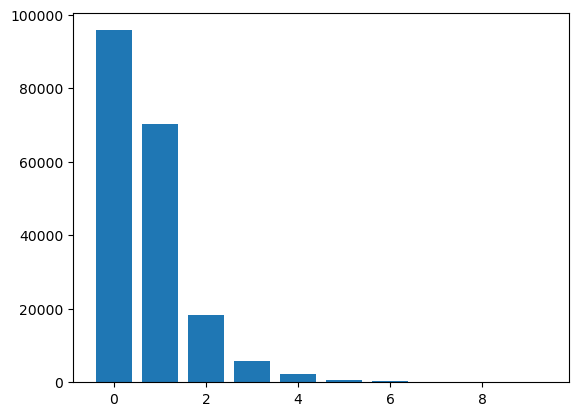

In [15]:
import matplotlib.pyplot as plt
# cut off trailing 0
how_many_attributes2 = how_many_attributes[:np.nonzero(how_many_attributes)[0][-1]+1]
print(how_many_attributes)
print(how_many_attributes/np.sum(how_many_attributes))
# print a histogram of the number of attributes per image
plt.bar(range(len(how_many_attributes)), how_many_attributes)
plt.show()

# Check how well a histogram predictor performs

### preprocess the filtered graphs

In [1]:
import sys
from os.path import dirname, abspath
import torch
d = abspath(dirname('../'))
print(d)
sys.path.append(d)
import random
import PIL
from tqdm import tqdm
from datasets.VG_graphs import get_realistic_graphs_dataset

/local/home/jthomm/GraphCLIP


In [2]:
filtered_graphs_path = "/local/home/jthomm/GraphCLIP/datasets/visual_genome/processed/"
filtered_graphs = filtered_graphs = torch.load(filtered_graphs_path + "filtered_graphs.pt")
list_to_iterate = get_realistic_graphs_dataset()
ids_in_adv = [l['original_graph'].image_id for l in list_to_iterate]

In [3]:
from tqdm import tqdm

histogram = {}
for graph in tqdm(filtered_graphs):
    if graph.image_id in ids_in_adv:
        continue
    for edge in graph.edges:
        key = graph.nodes[edge[0]]['name'] + " " + graph.nodes[edge[1]]['name']
        if key not in histogram:
            histogram[key] = [graph.edges[edge]['predicate']]
        else:
            histogram[key].append(graph.edges[edge]['predicate'])
# only keep the most common predicate per edge
for key in histogram:
    histogram[key] = histogram[key].count # max(set(histogram[key]), key=histogram[key].count)

100%|██████████| 97216/97216 [00:01<00:00, 61986.32it/s]


In [4]:
correct = 0
total = 0
for d in list_to_iterate:
    original_graph = d['original_graph']
    adv_graph = d['adv_graph']
    changed_edge = d['changed_edge']
    image_id = original_graph.image_id
    edge = original_graph.nodes[changed_edge[0]]['name'] + " " + original_graph.nodes[changed_edge[1]]['name']
    orig_pred = original_graph.edges[changed_edge]['predicate']
    adv_pred = adv_graph.edges[changed_edge]['predicate']

    orig_predicate_confidence = histogram[edge](orig_pred)
    adv_predicate_confidence = histogram[edge](adv_pred)
    if orig_predicate_confidence > adv_predicate_confidence:
        correct += 1
    total += 1
    # print("original relationship confidence:", original_rel_confidence)
    # print("adversarial relationship confidence:", adversarial_rel_confidence)
    # break
print("accuracy:", correct/total)


accuracy: 0.8543689320388349
